In [1]:
!python --version

Python 3.10.6


In [2]:
# If you want to use latex with matplotlib
#!apt install -y texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super
#!pip install -y latex

# Libraries and global variables

In [2]:
# ----------------------------------------------------------------------
# Import main libraries
# ----------------------------------------------------------------------

import numpy as np
from numpy import linalg as la

# Graphic tools
import matplotlib.pyplot as plt
import matplotlib

# Animation tools
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Source Seeking Tools
from SS_tools.toolbox import _zoom_range, M_rot
from SS_tools.scalar_field import *

from SS_tools.simulations import *
from SS_tools.plot_simulations import *

# ----------------------------------------------------------------------
# General configuration
# ----------------------------------------------------------------------

# Fix the random seed
np.random.seed(2023)

# Tell matplotlib to use latex
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False

# Fix font size
font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Global variables
# ----------------------------------------------------------------------

# 90º rotational matrix
E = M_rot(np.pi/2)

# Source Seeking Simulations

## (WIP) Simulación tipo 3: Varios clusters de uniciclos con una misma misión

Estas simulaciones continuan con la dinámica de uniciclos, pero ahora podemos tener varios clusters.

En este caso tendremos dos clases distintas:
  * *unicycle_cluster* se encargará de simular la física de cada cluster, por separado.
  * *arquimides_sim3* es el demonio que gestionará a todos los clusters: indicará si existen colisiones y cuándo hay que dar el siguiente paso de integración en la simulación.

Por último tenemos la clase *data_collector*, encargada de recolectar los datos de la simulación, para todo cluster *k* y tiempo *t*.

In [3]:
# ----------------------------------------------------------------------
# Simulation 3 class (+ unicycle_cluster)
# ----------------------------------------------------------------------

"""
Unicycle_cluster
----------------
  * sigma_field: objeto de clase "sigma" que contiene toda la información del campo escalar.
  * n_agents: número de agentes que hay en el cluster.
  * x0: Vector de parámetros iniciales [t0,p0,v0,phi0]
    - t0: tiempo inicial de la simulación
    - p0: matriz con la posición inicial de cada agente.
    - v0: velocidad constante para todos los agentes.
    - phi0: heading inicial de cada uniciclo.
  * kd: ganancia del controlador GVF (proporcional a la velocidad angular)
  * neightbors: referencia a los clusters que se encuentran en peligro de colisión.

IMPORTANTE: ¡En número de filas en p0 y phi0 debe de coincidir con n_agents!
"""
class unicycle_cluster:
  def __init__(self, id, sigma_field, n_agents, x0, dt=0.01, kd=0.5):
    self.id = id
    self.N = n_agents
    self.dt = dt

    # Generamos el simulation frame
    self.sim_frame = sim_frame(self.N, [x0[0],x0[1],x0[3]], self.dt)

    # Estados de esta simulación
    self.vf = x0[2]                                    # Velocidad común constante
    self.omega_i = np.zeros(self.N)                    # Acción de control
    self.sigma_field = sigma_field                     # Clase campo escalar
    self.sigma = self.sigma_field.value(x0[1])         # Sigmas medidos (N x 1)

    self.rc = np.mean(x0[1], axis=0)
    self.X = x0[1] - self.rc                           # Geometría del enjambre
    self.l_sigma_hat = np.zeros(2)

    # Variables que el cluster utilizará cuando tenga vecinos
    self.neightbors = {}
    self.rc_tilde = self.rc
    self.X_tilde = (self.X + self.rc) - self.rc_tilde
    self.l_sigma_hat_i = np.zeros(2)

    # Parámetros del controlador GVF
    self.kd = kd

    # Data dictionary
    self.update_data()

  """
  Actualiza los datos a extraer por el colector.
  """
  def update_data(self):
    # Cálculos previos
    e = la.norm(self.rc - self.sigma_field.mu)
    d = la.norm(self.X, axis=1)
    rc_grad = self.sigma_field.grad(self.rc)[0]
    rc_grad = rc_grad/la.norm(rc_grad)
    rc_tilde_grad = self.sigma_field.grad(self.rc_tilde)[0]
    rc_tilde_grad = rc_tilde_grad/la.norm(rc_tilde_grad)

    l_sigma_hat_norm = la.norm(self.l_sigma_hat)
    if l_sigma_hat_norm != 0:
      l_sigma_hat = self.l_sigma_hat / l_sigma_hat_norm
    else:
      l_sigma_hat = np.zeros(2)

    l_sigma_hat_norm_i = la.norm(self.l_sigma_hat_i)
    if l_sigma_hat_norm_i != 0:
      l_sigma_hat_i = self.l_sigma_hat_i / l_sigma_hat_norm_i
    else:
      l_sigma_hat_i = np.zeros(2)

    # Actualizamos el diccionario de datos
    self.data_dic = {"N":self.N, "dt":self.dt, "tf":self.get_tf(),
                     "pf":self.get_pf(), "phif":self.get_phif()[:,None], "rc":self.rc,
                     "e":e, "d":d[:,None], "sigma":self.sigma[:,None], "omega_i":self.omega_i[:,None],
                     "l_sigma":l_sigma_hat, "l_sigma_i":l_sigma_hat_i, "rc_tilde":self.rc_tilde,
                     "rc_grad":rc_grad, "rc_tilde_grad":rc_tilde_grad}

  """
  Extraer los resultados de la simulación.
  """
  def get_tf(self):
    return self.sim_frame.tf

  def get_pf(self):
    return self.sim_frame.states[0]

  def get_phif(self):
    return self.sim_frame.states[1]

  """
  Calcular l_sigma_hat.
  """
  def LsigmaHat(self, X):
    return self.sim_frame.L_sigma(X, self.sigma)

  """
  Controlador GVF classic asumiendo omega_d = 0
  """
  def gvf_control(self):
    l_sigma_hat_norm = la.norm(self.l_sigma_hat)
    if l_sigma_hat_norm != 0:
      l_sigma_hat = self.l_sigma_hat / l_sigma_hat_norm
    else:
      l_sigma_hat = np.zeros(2)
    phi = self.get_phif()
    vel_hat = np.array([np.cos(phi), np.sin(phi)]).T
    omega = - self.kd * angle_of_vectors(l_sigma_hat * np.ones((self.N,2)), vel_hat)
    return omega

  """
  Dinámica libre que sigue dirección de ascenso (celeridad constante)
    * X: matriz de distancias relativas al centroide (N x n) xi = [px, py, pz]
    * sigma: vector con las medidas de sigma_field de cada agente (N x 1)
  """
  def unicycle_kinematics(self):
    phi = self.get_phif()
    p_dot = self.vf * np.array([np.cos(phi), np.sin(phi)]).T
    phi_dot = self.omega_i
    return p_dot, phi_dot

  def shape_control(self):
    return (self.Xd - self.X)/10

  """
  Integración paso a paso.
  """
  def int_step(self):
    self.rc = np.mean(self.get_pf(), axis=0)
    self.X = self.get_pf() - self.rc
    self.sigma = self.sigma_field.value(self.get_pf())

    # Comprobamos si tenemos vecinos en peligro de colisión
    Kn = len(self.neightbors)
    if Kn > 0:
      rc_sum = self.rc
      available_l_sigma = True
      for cluster in self.neightbors.values():
        rc_sum = rc_sum + cluster.rc
        available_l_sigma *= la.norm(cluster.l_sigma_hat_i) > 0
      self.rc_tilde = rc_sum / (Kn+1)
      self.X_tilde  = (self.X + self.rc) - self.rc_tilde
      self.l_sigma_hat_i = self.LsigmaHat(self.X)
      #self.l_sigma_hat_i /= la.norm(self.l_sigma_hat_i)

      if available_l_sigma:
        l_sigma_mean = self.l_sigma_hat_i + 0
        for cluster in self.neightbors.values():
          l_sigma_mean += cluster.l_sigma_hat_i
        self.l_sigma_hat = l_sigma_mean / (Kn+1)
      else:
        self.l_sigma_hat = self.LsigmaHat(self.X)

    else:
      self.rc_tilde = self.rc
      self.X_tilde  = self.X
      self.l_sigma_hat = self.LsigmaHat(self.X)
      self.l_sigma_hat_i = self.l_sigma_hat

    # Calculamos x_dot y se lo pasamos al sim_frame
    self.omega_i = self.gvf_control()
    x_dot = self.unicycle_kinematics()
    self.sim_frame.int_euler(x_dot)

    # Actualizamos los datos
    self.update_data()

# ----------------------------------------------------------------------
# Simulation 3 class
# ----------------------------------------------------------------------

"""
Simulation 3
------------
  * clusters: lista que contendrá referencias a objetos de tipo unicycle_cluster
  * r: radio de colisión
  * sigma: umbrales para la función de colisión [sigma_merge, sigma_split]
"""
class arquimides_sim3:
  def __init__(self, clusters=[], w=1, sigma=[0.5, 1.4], hk=2):
    self.clusters = clusters
    self.Nc = len(self.clusters)

    self.N = 0
    for cluster in self.clusters: # TODO: Muy temporal esto
      self.N += cluster.N

    self.w = w
    self.sigma = sigma
    self.hk = hk

  """
  Funciones para añadir y eliminar clusters de la simulación
  """
  def add_cluster(self, cluster):
    self.clusters.append(cluster)
    self.Nc = len(self.clusters)

  def rm_cluster(self, cluster):
    self.clusters.remove(cluster)
    self.Nc = len(self.clusters)

  """
  Extrae tf de alguno de los clusters (da igual cual)
  """
  def get_tf(self):
    if len(self.clusters) > 0:
      return self.clusters[0].get_tf()
    else:
      return None

  """
  Comprueba si hay peligro de colisión entre los clusters y, si es así, le
  pasa a cada cluster la referencia de aquellos con los que va a colisionar.
  """
  def check_for_colisions(self):
    for cluster in self.clusters: # Para todos los clusters
      for cluster_ki in self.clusters: # Comparamos con todos los clusters
        if (cluster.id != cluster_ki.id): # menos conmigo mismo...

          dist_clusters   = la.norm(cluster.rc - cluster_ki.rc)
          col_hazard_dist = np.max(cluster.data_dic["d"]) + np.max(cluster_ki.data_dic["d"]) + self.w
          if (dist_clusters <= col_hazard_dist) and cluster_ki.id not in cluster.neightbors.keys():
            cluster.neightbors.update({cluster_ki.id:cluster_ki})

          elif (dist_clusters > col_hazard_dist) and cluster_ki.id in cluster.neightbors.keys():
            cluster.neightbors.pop(cluster_ki.id, None)

  def check_for_colisions_h(self):
    for cluster in self.clusters: # Para todos los clusters
      for cluster_ki in self.clusters: # Comparamos con todos los clusters
        if (cluster.id != cluster_ki.id): # menos conmigo mismo...

          p1 = cluster.data_dic["rc"]
          p2 = cluster_ki.data_dic["rc"]
          phi1 = cluster.get_phif()
          phi2 = cluster_ki.get_phif()
          v1 = cluster.data_dic["l_sigma_i"]
          v2 = cluster_ki.data_dic["l_sigma_i"]

          prel = p2 - p1
          prel_sqr = np.dot(prel, prel)
          prel_norm = np.sqrt(prel_sqr)

          r = np.max(cluster_ki.data_dic["d"]) + self.w # collision rad
          if prel_sqr > r**2:
            cos_alfa = np.sqrt(prel_sqr - r**2)/prel_norm
          else: # Han colisionado...
            cos_alfa = 0

          vrel = v2 - v1
          vrel_norm = np.sqrt(np.dot(vrel, vrel))

          # h(x,t)
          h = np.dot(prel, vrel)/prel_norm/vrel_norm/2 + cos_alfa

          if (h <= self.sigma[0]) and cluster_ki.id not in cluster.neightbors.keys():
            cluster.neightbors.update({cluster_ki.id:cluster_ki})
            cluster_ki.neightbors.update({cluster.id:cluster})

          elif (h > self.sigma[1]) and cluster_ki.id in cluster.neightbors.keys():
            cluster.neightbors.pop(cluster_ki.id, None)
            cluster_ki.neightbors.pop(cluster.id, None)

  """
  Paso de integración para todos los clusters.
  """
  def int_step(self):
    self.check_for_colisions_h()
    for cluster in self.clusters:
      cluster.int_step()

# ----------------------------------------------------------------------
# Utilidad para la simulación 3
# ----------------------------------------------------------------------

"""
Clase para recolectar los datos de la simulación, para todos los frames y
clusters.
  * simulation: simulador que controla a los clusters.
  * data_labels: datos que se desean extraer.

Devuelve como resultado:
  * data: un diccionario con el siguiente formato:

EJEMPLO: data = {"dt":dt, "tf":tf, "pf":pf} donde, tras hacer pf = get("pf"),
         pf.shape = [501,2,20,2].
"""
class data_collector:
  def __init__(self, simulation, data_labels):
    self.simulation = simulation
    self.data = {'dt':None, 'tf':None}
    for label in data_labels:
      self.data.update({label:[]})

  def collect(self):
    tf_flag = True
    for label in self.data:
      # Variables que solo han de asignarse una vez
      if label == "dt":
        if self.data[label] == None:
          self.data["dt"]  = self.simulation.clusters[0].dt
      elif label == "tf":
        if tf_flag:
          tf_flag = False
          self.data["tf"]  = self.simulation.clusters[0].get_tf()
      # Datos que valos a recolectar de todos los clusters
      else:
        data_stack = None
        for cluster in self.simulation.clusters:
          data_cluster = np.array(cluster.data_dic[label], ndmin=2)
          if data_stack is None:
            data_stack = data_cluster
          else:
            data_stack = np.concatenate((data_stack, data_cluster), axis=0)
        self.data[label].append(np.squeeze(data_stack))

  def get(self, label):
    if label == "dt":
      return self.data["dt"]
    elif label == "tf":
      return self.data["tf"]
    else:
      return np.array(self.data[label], dtype=object)

  def get_mask(self):
    sim = self.simulation
    mask = []
    for ki in range(sim.Nc):
      mask = np.concatenate((mask, np.ones(sim.clusters[ki].N)*ki))
    return mask

### SIM 6: Varios clusters en busca de la fuente

In [4]:
# ----------------------------------------------------------------------
# Generamos el campo escalar
# ----------------------------------------------------------------------
n = 2
max_int = 20
mu = [40,40]

sigma_func = sigma_fract(k=0.04, dev=[30,10], mu=mu)
#sigma_func = sigma_nonconvex(k=0.04, dev=30, mu=mu)
#sigma_func = sigma_gauss(mu, max_intensity=max_int, dev=30, n=n)
sigma_field = sigma(sigma_func)

# ----------------------------------------------------------------------
# Parámetros de la simulación
# ----------------------------------------------------------------------
dt = 0.3
t0 = 0
t_sim_final = 200

# Estado inicial de los agentes y número de agentes
n_agents1 = 20
n_agents2 = 10
# rc0_k1 = [-35, -50]
# rc0_k2 = [-35,   0]
rc0_k1 = [-30, -90]
rc0_k2 = [-80, -30]
r, h = 10, 2
lims = [3, 15]
border_noise = 0.6

p0_cir1 = circular_distrib(n_agents1, n, [0,0], r, h, border_noise)
p0_cir2 = circular_distrib(n_agents2, n, [0,0], r, h, border_noise)
p0_sqr1 = XY_distrib(n_agents1, n, [0,0], lims, border_noise)
p0_sqr2 = XY_distrib(n_agents2, n, [0,0], lims, border_noise)

p0_k1 = rc0_k1 + p0_sqr1
p0_k2 = rc0_k2 + p0_sqr2

v0 = 2.0
phi0_k1 = np.random.rand(n_agents1) * np.pi
phi0_k2 = np.random.rand(n_agents2) * np.pi

kd = 0.2

In [5]:
# ----------------------------------------------------------------------
# Simulación numérica
# ----------------------------------------------------------------------

# Inicializamos la simulación
k1 = unicycle_cluster(0, sigma_field, n_agents1, [t0, p0_k1, v0, phi0_k1], dt, kd)
k2 = unicycle_cluster(1, sigma_field, n_agents2, [t0, p0_k2, v0, phi0_k2], dt, kd)
sim = arquimides_sim3([k1, k2], w=20, sigma=[0.1,0.7], hk=2)

data_col = data_collector(sim, ["pf", "phif", "rc", "e", "d", "sigma", "omega_i",
                                "l_sigma", "rc_grad", "rc_tilde", "l_sigma_i",
                                "rc_tilde_grad"])

# Realizamos toda la simulación mumerica
data_col.collect()
field_rot = None

while (data_col.get("tf") <= t_sim_final - dt/10):
  sim.int_step()
  data_col.collect()

tf = data_col.get("tf")
print("tf:", tf)

# Pasamos todas las listas a numpy arrays para facilitar la indexación
xdata = data_col.get("pf")[..., 0]
ydata = data_col.get("pf")[..., 1]
phidata = data_col.get("phif")
rc_xdata = data_col.get("rc")[..., 0]
rc_ydata = data_col.get("rc")[..., 1]

edata = data_col.get("e")
ddata = data_col.get("d")
sigma_data = data_col.get("sigma")
omega_data = data_col.get("omega_i")

l_sigma = data_col.get("l_sigma")
rc_grad = data_col.get("rc_grad")
rc_tilde_grad = data_col.get("rc_tilde_grad")

cluster_mask = data_col.get_mask()
N_data = np.unique(cluster_mask, return_counts=True)[1]

l_sigma_i  = data_col.get("l_sigma_i")
rc_tilde = data_col.get("rc_tilde")

print("\n ------ Data arrays dimension ------")
print("xdata"   , xdata.shape)
print("ydata"   , ydata.shape)
print("phidata" , phidata.shape)
print("rc_xdata", rc_xdata.shape)
print("rc_ydata", rc_ydata.shape)
print("edata", edata.shape)
print("ddata", ddata.shape)
print("sigma_data", sigma_data.shape)
print("omega_data", omega_data.shape)
print("l_sigma", l_sigma.shape)
print("rc_grad", rc_grad.shape)
print("cluster_mask", cluster_mask.shape)
print("N_data =", N_data)

print("l_sigma_i", l_sigma_i.shape)
print("rc_tilde", rc_tilde.shape)

#print(ydata[0,cluster_mask==1])
# print(rc_xdata[0:10,0])
# print(rc_ydata[0:10,0])
# print(rc_xdata[0:10,1])
# print(rc_ydata[0:10,1])

/tmp/ipykernel_87763/3396816336.py:258: RuntimeWarning: invalid value encountered in double_scalars
  h = np.dot(prel, vrel)/prel_norm/vrel_norm/2 + cos_alfa


tf: 200.10000000000187

 ------ Data arrays dimension ------
xdata (668, 30)
ydata (668, 30)
phidata (668, 30)
rc_xdata (668, 2)
rc_ydata (668, 2)
edata (668, 2)
ddata (668, 30)
sigma_data (668, 30)
omega_data (668, 30)
l_sigma (668, 2, 2)
rc_grad (668, 2, 2)
cluster_mask (30,)
N_data = [20 10]
l_sigma_i (668, 2, 2)
rc_tilde (668, 2, 2)


### SIM 7: Simulación inifinita, aparecen clusters que mueren al llegar a la fuente

### Graficación compatible con las simulaciones tipo 3

In [6]:
palette = ["b", "green", "r"]
legend_labels = ["active", "computer unit", "non-active", "centroid"]
figsize = np.array([16, 9])

delta = 0.8
agents_cicle_rad = 0.12
agents_active_lw = 0.4
lw_centroid = 0.6
lider_lw  = 1.5

alfa_init = 0.2
tail_time = 5

# Tamaño de los iconos
kw_patch = {"size":1.5, "lw":0.5}

# Dimensiones de las flechas
l_sigma_color = "red"
arr_kw = {"width":0.003, "scale":25, "zorder":10}
thr_arrows = -1

# Límites de la gráfica en ambos casos
xlim, ylim = 180, 180
kw_draw_field = {"xlim":1.2*xlim, "ylim":1.2*ylim, "n":300, "contour_levels":20}

# Cálculos con estos parámetros que servirán para static plot y animación
tail_frames = int(tail_time/dt)

color = [palette[1] if n == 0 else palette[0] for n in range(np.max(N_data))]
lw = [lider_lw if n == 0 else agents_active_lw for n in range(np.max(N_data))]
z_order = [5 if n == 0 else 4 for n in range(np.max(N_data))]

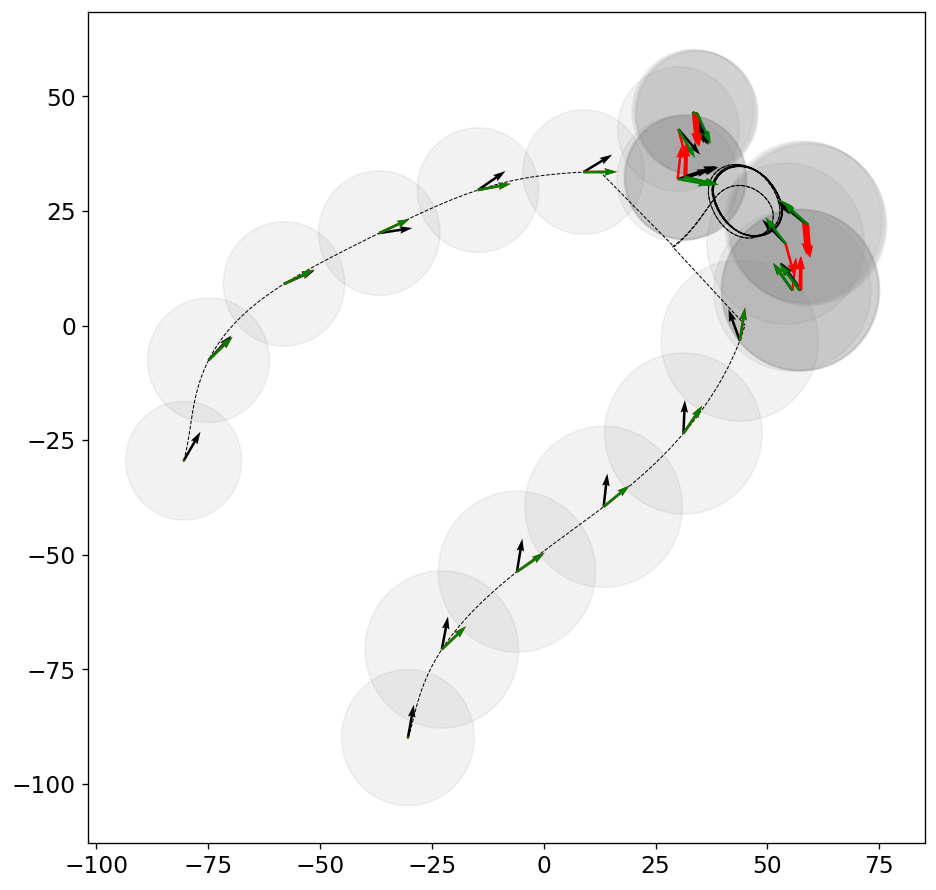

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(9, 9), dpi=120)
ax = fig.subplots()

mult = 40
frames = int((tf + 11/10*dt)/dt/mult)
for ki in range(2):
  #ax.plot(rc_xdata[:,ki],rc_ydata[:,ki], c="b", ls="--", lw=lw_centroid)
  ax.plot(rc_tilde[:,ki,0], rc_tilde[:,ki,1], c="k", ls="--", lw=lw_centroid)
  for frame in range(frames):
    sigma_field.draw_grad([rc_xdata[frame*mult,ki], rc_ydata[frame*mult,ki]], ax, **arr_kw)
    ax.quiver(rc_xdata[frame*mult,ki], rc_ydata[frame*mult,ki],
              l_sigma[frame*mult,ki,0], l_sigma[frame*mult,ki,1], color=l_sigma_color, **arr_kw)
    ax.quiver(rc_xdata[frame*mult,ki], rc_ydata[frame*mult,ki],
              l_sigma_i[frame*mult,ki,0], l_sigma_i[frame*mult,ki,1], color="green", **arr_kw)
    ax.add_patch(plt.Circle((rc_xdata[frame*mult,ki], rc_ydata[frame*mult,ki]), np.max(ddata[frame*mult,cluster_mask==ki]), color="grey", alpha=0.1))

plt.show()

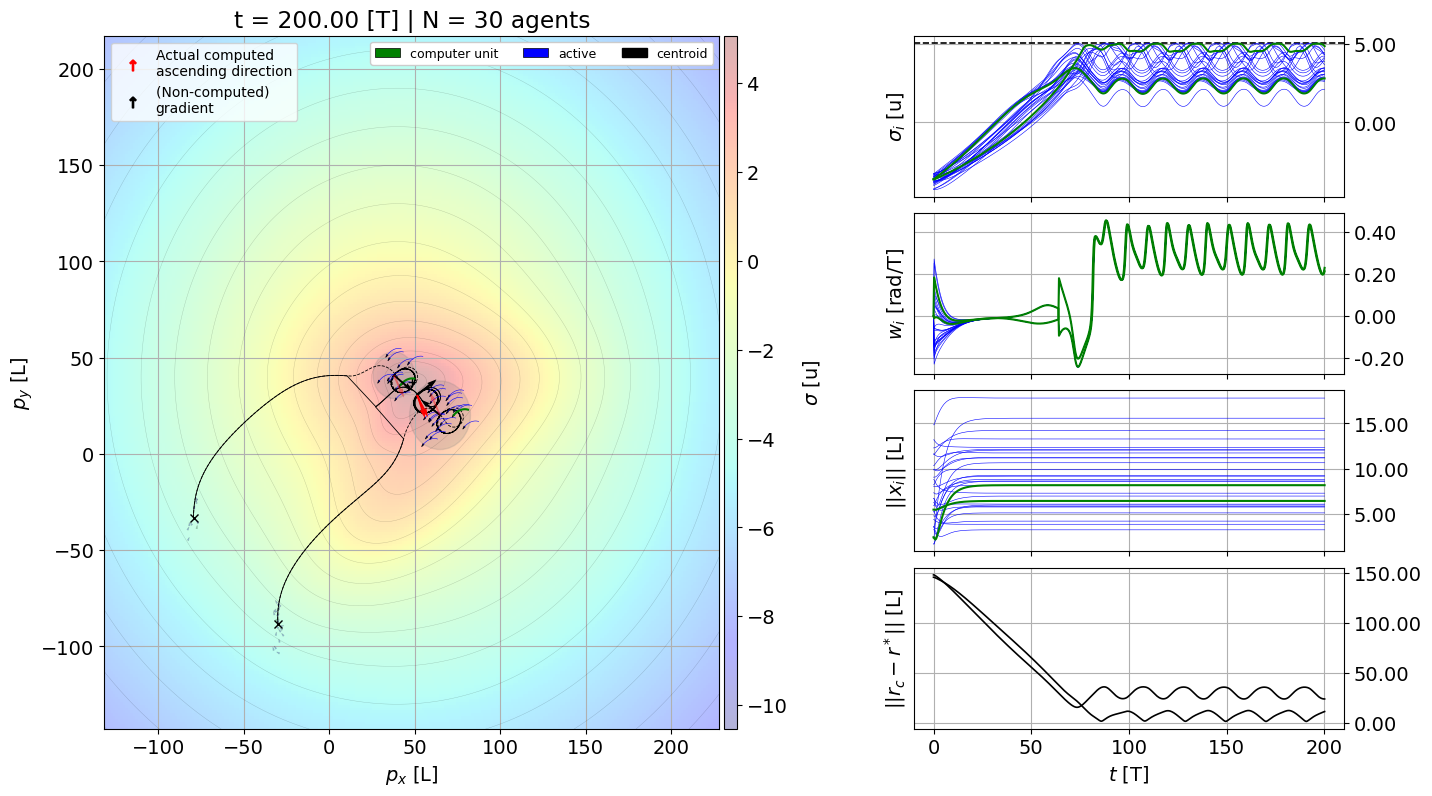

In [7]:
"""
Mostramos el estado final de la simulación (static plot).
"""
# Nos aseguramos de que la graficación interactiva está desactivada
%matplotlib inline

font_params = {'size' : 14}
matplotlib.rc('font', **font_params)

# ----------------------------------------------------------------------
# Comenzamos a graficar
# ----------------------------------------------------------------------
li = xdata.shape[0] - 1
legend_flags = [False, False, False]

# FIGURE init
# ----------------
fig = plt.figure(figsize=figsize, dpi=100)
grid = plt.GridSpec(4, 7, hspace=0.1, wspace=7)
main_ax       = fig.add_subplot(grid[:, 0:4])
sigma_data_ax = fig.add_subplot(grid[0, 4:8], xticklabels=[])
omega_data_ax = fig.add_subplot(grid[1, 4:8], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[2, 4:8], xticklabels=[])
edata_ax      = fig.add_subplot(grid[3, 4:8])

# Configuración de los ejes
main_ax.set_xlim([sigma_field.mu[0]-xlim, sigma_field.mu[0]+xlim])
main_ax.set_ylim([sigma_field.mu[1]-ylim, sigma_field.mu[1]+ylim])
main_ax.set_ylabel(r"$p_y$ [L]")
main_ax.set_xlabel(r"$p_x$ [L]")

sigma_data_ax.set_ylabel(r"$\sigma_i$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.yaxis.tick_right()
sigma_data_ax.grid(True)
omega_data_ax.set_ylabel(r"$w_i$ [rad/T]")
omega_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
omega_data_ax.yaxis.tick_right()
omega_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [L]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.yaxis.tick_right()
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [T]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [L]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.yaxis.tick_right()
edata_ax.grid(True)


# MAIN_AXS
# ----------------
if field_rot is not None:
  sim.sigma_field.rot = field_rot[li]
sigma_field.draw(fig, main_ax, **kw_draw_field)

main_ax.set_title(r"t = {0:.2f} [T] | N = {1:d} agents".format(t_sim_final, sim.N))
main_ax.grid(True)

# Agentes
for ki in range(sim.Nc):
  for n in range(N_data[ki]):
    n_ = np.sum(N_data[0:ki]) + n if ki > 0 else n
    icon_init = unicycle_patch([xdata[0,n_], ydata[0,n_]], phidata[0,n_], color[n], **kw_patch)
    icon_init.set_alpha(alfa_init)
    icon = unicycle_patch([xdata[li,n_], ydata[li,n_]], phidata[li,n_], color[n], **kw_patch)

    icon_init.set_zorder(z_order[n])
    icon.set_zorder(z_order[n])

    for i in range(len(palette)):
      if not legend_flags[i] and color[n] == palette[i]:
        icon.set_label(legend_labels[i])
        legend_flags[i] = True

    main_ax.add_patch(icon_init)
    main_ax.add_patch(icon)
    main_ax.plot(xdata[li-tail_frames:li,n_],ydata[li-tail_frames:li,n_],
                c=color[n], ls="-", lw=lw[n], zorder=z_order[n])

# Centroides
for ki in range(sim.Nc):
  icon_centroid = plt.Circle((rc_xdata[li,ki], rc_ydata[li,ki]), agents_cicle_rad*2, color="k")
  main_ax.add_patch(icon_centroid)

  main_ax.plot(rc_xdata[0,ki],rc_ydata[0,ki], "x", c="k")
  main_ax.plot(rc_xdata[:,ki],rc_ydata[:,ki], c="k", ls="--", lw=lw_centroid)
  main_ax.plot(rc_tilde[:,ki,0], rc_tilde[:,ki,1], c="k", ls="-", lw=lw_centroid)

  if ki == 0:
    icon_centroid.set_label(legend_labels[3])

  # Límites de colisión del cluster
  main_ax.add_patch(plt.Circle((rc_xdata[li,ki], rc_ydata[li,ki]), np.max(ddata[li,cluster_mask==ki]), color="grey", alpha=0.2))

  # Flecha gradiente
  q_grad = sigma_field.draw_grad([rc_tilde[li,ki,0], rc_tilde[li,ki,1]], main_ax, **arr_kw)
  q_grad_i = sigma_field.draw_grad([rc_xdata[li,ki], rc_ydata[li,ki]], main_ax, **arr_kw)
  q_Lsig = main_ax.quiver(rc_tilde[li,ki,0], rc_tilde[li,ki,1], l_sigma[li,ki,0], l_sigma[li,ki,1],
                          color=l_sigma_color, **arr_kw)
  q_Lsig_i = main_ax.quiver(rc_xdata[li,ki], rc_ydata[li,ki], l_sigma_i[li,ki,0], l_sigma_i[li,ki,1],
                            color=l_sigma_color, alpha=0.4, **arr_kw)

# Legendas
main_ax.legend(loc="upper right", ncol=sim.N,
               fancybox=True, framealpha=1, prop={'size': 9})

arr1 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
arr2 = plt.scatter([],[],c='k'  ,marker=r'$\uparrow$',s=60)
leg = Legend(main_ax, [arr1, arr2], ["Actual computed \nascending direction", "(Non-computed) \ngradient"],
             loc="upper left", prop={'size': 10})
main_ax.add_artist(leg)

# DATA_AXS
# ----------------
time_vec = np.linspace(0, sim.get_tf(), int((sim.get_tf() + 11/10*dt)/dt))

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)

for ki in range(sim.Nc):
  for n in range(N_data[ki]):
    n_ = np.sum(N_data[0:ki]) + n if ki > 0 else n
    sigma_data_ax.plot(time_vec, sigma_data[:,n_], c=color[n], lw=lw[n], zorder=z_order[n])
    omega_data_ax.plot(time_vec, omega_data[:,n_], c=color[n], lw=lw[n], zorder=z_order[n])
    ddata_ax.plot(time_vec, ddata[:,n_], c=color[n], lw=lw[n], zorder=z_order[n])
  edata_ax.plot(time_vec, edata[:,ki], c="k", lw=1.2)

# Visualizamos el resultado :)
plt.show()

In [8]:
"""
Animación de la simulación numérica.
"""

# Activamos la graficación interactiva (necesario para animar en notebooks)
matplotlib.use('webagg')

# ----------------------------------------------------------------------
# Parámetros de la animación
# ----------------------------------------------------------------------

# Resolución de los frames de la animación
res = 480
res = 1920 # Full HD
#res = 2560 # 2k
#res = 3880 # 4K

# Variables temporales
anim_tf = tf
anim_frames = int((anim_tf + 11/10*dt)/dt)
# anim_tf = 1
# anim_frames = 11

# Efecto zoom
min_zoom, max_zoom = 1.1, 1.2
min_zoom_t, max_zoom_t = 10, 40

# ----------------------------------------------------------------------
# Mostramos una animación de la simulación numérica
# ----------------------------------------------------------------------
if min_zoom_t <= max_zoom_t:
  _min_z, _max_z = min_zoom, max_zoom
  _min_t, _max_t = min_zoom_t, max_zoom_t
else:
  _min_z, _max_z = max_zoom, min_zoom
  _min_t, _max_t = max_zoom_t, min_zoom_t


# FIGURE init
# ----------------
fig = plt.figure(figsize=figsize, dpi=res/figsize[0])
grid = plt.GridSpec(4, 7, hspace=0.1, wspace=7)
main_ax       = fig.add_subplot(grid[:, 0:4])
sigma_data_ax = fig.add_subplot(grid[0, 4:8], xticklabels=[])
omega_data_ax = fig.add_subplot(grid[1, 4:8], xticklabels=[])
ddata_ax      = fig.add_subplot(grid[2, 4:8], xticklabels=[])
edata_ax      = fig.add_subplot(grid[3, 4:8])

# Configuración de los ejes
main_ax.set_xlim([-3*xlim,2*xlim])
main_ax.set_ylim([-3*ylim,2*ylim])
main_ax.set_ylabel(r"$p_y$ [L]")
main_ax.set_xlabel(r"$p_x$ [L]")
main_ax.grid(False)

sigma_data_ax.set_ylabel(r"$\sigma_i$ [u]")
sigma_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
sigma_data_ax.yaxis.tick_right()
sigma_data_ax.grid(True)
omega_data_ax.set_ylabel(r"$w_i$ [rad/T]")
omega_data_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
omega_data_ax.yaxis.tick_right()
omega_data_ax.grid(True)
ddata_ax.set_ylabel(r"$||x_i||$ [L]")
ddata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
ddata_ax.yaxis.tick_right()
ddata_ax.grid(True)
edata_ax.set_xlabel(r"$t$ [T]")
edata_ax.set_ylabel(r"$||r_c - r^*||$ [L]")
edata_ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
edata_ax.yaxis.tick_right()
edata_ax.grid(True)


# MAIN_AX init
# ----------------

sigma_field.draw(fig, main_ax, **kw_draw_field)

# Agentes
lines_agents = []
icons_agents = []
legend_flags = [False, False, False]
for ki in range(sim.Nc):
  for n in range(N_data[ki]):
    n_ = np.sum(N_data[0:ki]) + n if ki > 0 else n
    icon_init = unicycle_patch([xdata[0,n_], ydata[0,n_]], phidata[0,n_], color[n])
    icon_init.set_alpha(alfa_init)
    icon = unicycle_patch([xdata[0,n_], ydata[0,n_]], phidata[0,n_], color[n])

    for i in range(len(palette)):
      if not legend_flags[i] and color[n] == palette[i]:
        icon.set_label(legend_labels[i])
        legend_flags[i] = True

    main_ax.add_patch(icon_init)
    main_ax.add_patch(icon)
    line, = main_ax.plot(xdata[0,n_], ydata[0,n_], c=color[n], ls="-", lw=lw[n], zorder=z_order[n])

    lines_agents.append(line)
    icons_agents.append(icon)

# Centroides
lines_centroids = []
lines_centroids_tilde = []
icons_centroids = []
q_grads, q_grads_i = [], []
q_Lsigs, q_Lsigs_i = [], []
for ki in range(sim.Nc):
  icon_centroid = plt.Circle((rc_xdata[0,ki], rc_ydata[0,ki]), agents_cicle_rad*2, color="k")

  main_ax.add_patch(icon_centroid)
  main_ax.plot(rc_xdata[0,ki],rc_ydata[0,ki], "x", c="k")
  line, = main_ax.plot(rc_tilde[0,ki,0], rc_tilde[0,ki,1], c="k", ls="-", lw=lw_centroid, alpha=0.4)
  line_tilde, = main_ax.plot(rc_xdata[0,ki], rc_ydata[0,ki], c="k", ls="--", lw=lw_centroid, alpha=0.4)

  lines_centroids.append(line)
  lines_centroids_tilde.append(line_tilde)
  icons_centroids.append(icon_centroid)

  if ki == 0:
    icon_centroid.set_label(legend_labels[3])

  # Flecha gradiente
  q_grad = sigma_field.draw_grad([rc_tilde[li,ki,0], rc_tilde[li,ki,1]], main_ax, **arr_kw)
  q_grad_i = sigma_field.draw_grad([rc_xdata[0,ki], rc_ydata[0,ki]], main_ax, alpha=0.4, **arr_kw)
  q_Lsig = main_ax.quiver(rc_tilde[0,ki,0], rc_tilde[0,ki,1], l_sigma[0,ki,0], l_sigma[0,ki,1],
                          color=l_sigma_color, **arr_kw)
  q_Lsig_i = main_ax.quiver(rc_xdata[0,ki], rc_ydata[0,ki], l_sigma_i[0,ki,0], l_sigma_i[0,ki,1],
                          color=l_sigma_color, alpha=0.4, **arr_kw)
  q_grads.append(q_grad)
  q_grads_i.append(q_grad_i)
  q_Lsigs.append(q_Lsig)
  q_Lsigs_i.append(q_Lsig_i)

# Leyenda y título
main_ax.legend(loc="upper right", ncol=sim.N,
               fancybox=True, framealpha=1, prop={'size': 9})

arr1 = plt.scatter([],[],c='red',marker=r'$\uparrow$',s=60)
arr2 = plt.scatter([],[],c='k'  ,marker=r'$\uparrow$',s=60)
leg = Legend(main_ax, [arr1, arr2], ["Actual computed \nascending direction", "(Non-computed) \ngradient"],
             loc="upper left", prop={'size': 10})
main_ax.add_artist(leg)

txt_title = main_ax.set_title("")


# DATA_AXS init
# ----------------
time_vec = np.linspace(0, anim_tf, anim_frames)

data_lines_plt = []
sigma_lines_data = []
omega_lines_data = []
ddata_lines_data = []
for ki in range(sim.Nc):
  for n in range(N_data[ki]):
    n_ = np.sum(N_data[0:ki]) + n if ki > 0 else n
    kw = dict(c=color[n], lw=lw[n])
    sigma_line_data, = sigma_data_ax.plot(time_vec, sigma_data[0:len(time_vec),n_], c=color[n], lw=lw[n], zorder=z_order[n])
    ddata_line_data, = ddata_ax.plot(time_vec, ddata[0:len(time_vec),n_], c=color[n], lw=lw[n], zorder=z_order[n])
    omega_line_data, = omega_data_ax.plot(time_vec, omega_data[0:len(time_vec),n_], c=color[n], lw=lw[n], zorder=z_order[n])
    sigma_lines_data.append(sigma_line_data)
    omega_lines_data.append(omega_line_data)
    ddata_lines_data.append(ddata_line_data)
  edata_ax.plot(time_vec, edata[0:len(time_vec),ki], c="k", lw=1.2)

sigma_data_ax.axhline(sigma_field.value(np.array(sigma_field.mu)), c="k", ls="--", lw=1.2)
sigma_line = sigma_data_ax.axvline(0, c="k", ls="--", lw=1.2)
omega_line = omega_data_ax.axvline(0, c="k", ls="--", lw=1.2)
dline = ddata_ax.axvline(0, c="k", ls="--", lw=1.2)
eline = edata_ax.axvline(0, c="k", ls="--", lw=1.2)

# ----------------------------------------------------------------------
# Comenzamos la animación de la simulación
# ----------------------------------------------------------------------

# Función para actualizar la animación
def animate(i):
  # Agentes
  for ki in range(sim.Nc):
    for n in range(N_data[ki]):
      n_ = np.sum(N_data[0:ki]) + n if ki > 0 else n
      icons_agents[n_].remove()
      icons_agents[n_] = unicycle_patch([xdata[i,n_], ydata[i,n_]], phidata[i,n_], color[n])
      main_ax.add_patch(icons_agents[n_])

      if i > tail_frames:
        lines_agents[n_].set_data(xdata[i-tail_frames:i,n_], ydata[i-tail_frames:i,n_])
      else:
        lines_agents[n_].set_data(xdata[0:i,n_], ydata[0:i,n_])

  # Para cada cluster...
  for cir in icons_centroids:
    cir.remove()
  for ki in range(sim.Nc):
    # Icono y línea del centroide
    icons_centroids[ki] = plt.Circle((rc_xdata[i,ki], rc_ydata[i,ki]), 0.1, color="k")
    icons_centroids[ki].set_zorder(6)

    lines_centroids_tilde[ki].set_data(rc_tilde[0:i,ki,0], rc_tilde[0:i,ki,1])
    lines_centroids[ki].set_data(rc_xdata[0:i,ki], rc_ydata[0:i,ki])
    main_ax.add_patch(icons_centroids[ki])

    # Flechas
    if edata[i,ki] > thr_arrows:
      q_grads[ki].set_offsets(np.array([rc_tilde[i,ki,0], rc_tilde[i,ki,1]]).T)
      q_grads_i[ki].set_offsets(np.array([rc_xdata[i,ki], rc_ydata[i,ki]]).T)
      q_Lsigs[ki].set_offsets(np.array([rc_tilde[i,ki,0], rc_tilde[i,ki,1]]).T)
      q_Lsigs_i[ki].set_offsets(np.array([rc_xdata[i,ki], rc_ydata[i,ki]]).T)
      q_grads[ki].set_UVC(rc_tilde_grad[i,ki,0], rc_tilde_grad[i,ki,1])
      q_grads_i[ki].set_UVC(rc_grad[i,ki,0], rc_grad[i,ki,1])
      q_Lsigs[ki].set_UVC(l_sigma[i,ki,0], l_sigma[i,ki,1])
      q_Lsigs_i[ki].set_UVC(l_sigma_i[i,ki,0], l_sigma_i[i,ki,1])
    else:
      q_grads[ki].set_offsets(np.array([2*xlim, 2*ylim]).T)
      q_grads_i[ki].set_offsets(np.array([2*xlim, 2*ylim]).T)
      q_Lsigs[ki].set_offsets(np.array([2*xlim, 2*ylim]).T)
      q_Lsigs_i[ki].set_offsets(np.array([2*xlim, 2*ylim]).T)

  t_ = i*dt
  # string format: https://www.w3schools.com/python/ref_string_format.asp
  txt_title.set_text('Frame = {0:>4} | Tf = {1:>5.2f} [T] | N = {2:>4} agents'.format(i, t_, sim.N))

  sigma_line.set_xdata(t_)
  omega_line.set_xdata(t_)
  dline.set_xdata(t_)
  eline.set_xdata(t_)

  # Efecto zoom
  if (i*dt < _min_t):
    zoom = _min_z
  elif (i*dt >= _min_t) and (i*dt <= _max_t):
    zoom = _min_z + (_max_z - _min_z) * (i*dt - _min_t)/(_max_t - _min_t)
  else:
    zoom = _min_z + (_max_z - _min_z)
  main_ax.set_xlim(0 + sigma_field.mu[0]/2 * i/anim_frames +
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))
  main_ax.set_ylim(0 + sigma_field.mu[1]/2 * i/anim_frames +
                   np.array(_zoom_range(-ylim, ylim, 0, zoom)))

  # Mostramos el porcentaje de carga de la simulación
  if (i % int((anim_frames-1)/10) == 0):
    print("tf = {0:>5.2f} | {1:.2%}".format(i*dt, i/(anim_frames-1)))

# Generamos la animación
print("Simulando {0:d} frames... \nEstado:".format(anim_frames))
anim = FuncAnimation(fig, animate, frames=anim_frames, interval=1000/60)
plt.close()

# Change the video bitrate as you like and add some metadata.
# writer = FFMpegWriter(fps=60, bitrate=7000)
# anim.save("path.mp4", writer=writer)

# Visualizamos la animación
HTML(anim.to_html5_video(embed_limit = 60)) # Esto tarda...

Simulando 668 frames... 
Estado:
tf =  0.00 | 0.00%
tf =  0.00 | 0.00%
tf = 19.80 | 9.90%
tf = 39.60 | 19.79%
tf = 59.40 | 29.69%
tf = 79.20 | 39.58%
tf = 99.00 | 49.48%
tf = 118.80 | 59.37%
tf = 138.60 | 69.27%
tf = 158.40 | 79.16%
tf = 178.20 | 89.06%
tf = 198.00 | 98.95%
